In [2]:
# Thank you to my teammates Isaih Battiste and Chris Hanes for partnership making this new poll
# Thank you also to these artificial intelligence (AI) Large Language Models (LLMs) for their help: Claude Sonnet 4.5, DeepSeek Version 3.2, and ChatGPT 5.1 Auto
# Thank you to Sports Reference Football (College) https://www.sports-reference.com/cfb/ for the data

# ============================================================================
# IC² PURE: CFP-Era Training Only (2014-2024)
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("="*80)
print("IC² PURE - CFP-ERA TRAINING (2014-2024)")
print("="*80)

# ----------------------------
# 1. LOAD AND CLEAN DATA 
# Add your own file path
# ----------------------------

df 

bad_rows = (
    ((df['Year'] == 2020) & (df['school_key'] == 'connecticut')) |
    ((df['Year'] == 2020) & (df['school_key'] == 'old-dominion')) |
    ((df['Year'] == 1937) & (df['school_key'] == 'virginia'))
)
df = df[~bad_rows].copy()

print(f"Full dataset: {df.shape[0]:,} team-seasons ({df['Year'].min()}-{df['Year'].max()})")

# ----------------------------
# 2. DEFINE CHAMPION TARGET (on full data for scoring)
# ----------------------------
df['Polls_AP Post'] = pd.to_numeric(df['Polls_AP Post'], errors='coerce')
df['Polls_CFP Final'] = pd.to_numeric(df['Polls_CFP Final'], errors='coerce')

df['champion_target'] = (
    (df['Polls_AP Post'] == 1) &
    (df['Polls_CFP Final'].notna())
).astype(int)

# ----------------------------
# 3. FILTER TO CFP ERA FOR TRAINING
# ----------------------------
df_cfp = df[df['Year'] >= 2014].copy()

print(f"CFP-era training set: {len(df_cfp):,} team-seasons (2014-2024)")
print(f"Champions: {df_cfp['champion_target'].sum()}")
print(f"Non-champions: {(df_cfp['champion_target']==0).sum()}")

champions = df_cfp[df_cfp['champion_target'] == 1]
print(f"\nNational Champions in training data:")
print(champions[['Year', 'school_key']].sort_values('Year', ascending=False).to_string(index=False))

# ----------------------------
# 4. CALCULATE CHAMPION THRESHOLDS (from CFP era only)
# ----------------------------
CHAMPION_THRESHOLDS = {
    'WIN_PCT': champions['Overall_Pct'].min(),
    'SRS': champions['SRS_SRS'].min(),
    'SOS': champions['SRS_SOS'].min()
}

print("\n" + "="*80)
print("HISTORICAL CHAMPION CRITERIA (CFP Era 2014-2024)")
print("="*80)
print(f"1. Win Percentage ≥ {CHAMPION_THRESHOLDS['WIN_PCT']:.3f}")
print(f"2. SRS Rating ≥ {CHAMPION_THRESHOLDS['SRS']:.1f}")
print(f"3. Strength of Schedule ≥ {CHAMPION_THRESHOLDS['SOS']:.1f}")

print(f"\nAverage champion statistics:")
print(f"  • Win%: {champions['Overall_Pct'].mean():.3f}")
print(f"  • SRS: {champions['SRS_SRS'].mean():.1f}")
print(f"  • SOS: {champions['SRS_SOS'].mean():.1f}")

# ----------------------------
# 5. TRAIN MODEL ON CFP ERA ONLY
# ----------------------------
features = ['Overall_Pct', 'SRS_SRS', 'SRS_SOS']

# Handle missing values in CFP training set
for col in features:
    df_cfp[col] = df_cfp[col].fillna(df_cfp[col].mean())

# Prepare training data
X_train = df_cfp[features]
y_train = df_cfp['champion_target']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train model
model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    solver='liblinear',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# Model coefficients
coef_df = pd.DataFrame({
    'feature': features,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\n" + "="*80)
print("IC² PURE MODEL COEFFICIENTS (CFP-Era Trained)")
print("="*80)
print(coef_df.to_string(index=False))

# ----------------------------
# 6. SCORE ALL DATA (including 2025)
# ----------------------------
# Handle missing values in full dataset
for col in features:
    df[col] = df[col].fillna(df[col].mean())

X_full = df[features]
X_full_scaled = scaler.transform(X_full)

df['IC2_score'] = model.predict_proba(X_full_scaled)[:, 1] * 100
df['IC2_rank'] = df.groupby('Year')['IC2_score'].rank(method='first', ascending=False)

# ----------------------------
# 7. CREATE CHAMPION PROFILE SCORES (on all data)
# ----------------------------
df['meets_win'] = (df['Overall_Pct'] >= CHAMPION_THRESHOLDS['WIN_PCT']).astype(int)
df['meets_srs'] = (df['SRS_SRS'] >= CHAMPION_THRESHOLDS['SRS']).astype(int)
df['meets_sos'] = (df['SRS_SOS'] >= CHAMPION_THRESHOLDS['SOS']).astype(int)

df['champion_profile'] = df['meets_win'] + df['meets_srs'] + df['meets_sos']

# ----------------------------
# 8. HISTORICAL ACCURACY (2014-2023, excluding 2024 from validation)
# ----------------------------
print("\n" + "="*80)
print("HISTORICAL ACCURACY (2014-2023)")
print("="*80)

actual_champs = df[(df['champion_target'] == 1) & (df['Year'] >= 2014) & (df['Year'] <= 2023)]
predicted_champs = df[(df['IC2_rank'] == 1) & (df['Year'] >= 2014) & (df['Year'] <= 2023)]

merged = actual_champs.merge(
    predicted_champs[['Year', 'school_key']],
    on='Year',
    suffixes=('_actual', '_predicted')
)
merged['correct'] = merged['school_key_actual'] == merged['school_key_predicted']
accuracy = merged['correct'].mean()

print(f"\nAccuracy: {merged['correct'].sum()}/{len(merged)} = {accuracy:.1%}")

print("\n✅ CORRECTLY PREDICTED:")
for _, row in merged[merged['correct']].sort_values('Year').iterrows():
    team_name = row['school_key_actual'].replace('-', ' ').title()
    print(f"  {row['Year']}: {team_name}")

if not merged['correct'].all():
    print("\n❌ MISSED:")
    for _, row in merged[~merged['correct']].sort_values('Year').iterrows():
        actual_name = row['school_key_actual'].replace('-', ' ').title()
        predicted_name = row['school_key_predicted'].replace('-', ' ').title()
        print(f"  {row['Year']}: Predicted {predicted_name}, Actual {actual_name}")

# ----------------------------
# 9. 2025 RANKINGS
# ----------------------------
df_2025 = df[df['Year'] == 2025].copy()
df_2025 = df_2025.sort_values('IC2_rank')

display_cols = [
    'school_key', 'Overall_Pct', 'SRS_SRS', 'SRS_SOS',
    'IC2_score', 'IC2_rank', 'champion_profile'
]

top25_2025 = df_2025[display_cols].head(25).copy()
top25_2025['school_key'] = top25_2025['school_key'].str.replace('-', ' ').str.title()
top25_2025.columns = [
    'Team', 'Win%', 'SRS', 'SOS',
    'IC² Score', 'IC² Rank', 'Champ Profile'
]

print("\n" + "="*80)
print("IC² PURE RANKINGS - 2025 TOP 25 (CFP-Era Model)")
print("="*80)
print(top25_2025.to_string(index=False))

# ----------------------------
# 10. TEAM ANALYSIS CARDS (TOP 5)
# ----------------------------
print("\n" + "="*80)
print("TEAM ANALYSIS CARDS - TOP 5")
print("="*80)

def create_team_card(team_data):
    """Generate detailed analysis card for a team"""
    card = []
    card.append(f"\n🏈 {team_data['Team'].upper()}")
    card.append("─" * 50)
    card.append(f"IC² Rank: #{int(team_data['IC² Rank'])}")
    card.append(f"IC² Score: {team_data['IC² Score']:.1f}")
    card.append(f"Champion Profile: {int(team_data['Champ Profile'])}/3 criteria")
    card.append("")
    
    # Champion criteria analysis
    card.append("CHAMPION CRITERIA ANALYSIS:")
    
    win_status = "✓" if team_data['Win%'] >= CHAMPION_THRESHOLDS['WIN_PCT'] else "✗"
    win_detail = f"{team_data['Win%']:.3f}" if win_status == "✓" else f"{team_data['Win%']:.3f} < {CHAMPION_THRESHOLDS['WIN_PCT']:.3f}"
    card.append(f"  {win_status} Win Percentage: {win_detail}")
    
    srs_status = "✓" if team_data['SRS'] >= CHAMPION_THRESHOLDS['SRS'] else "✗"
    srs_detail = f"{team_data['SRS']:.1f}" if srs_status == "✓" else f"{team_data['SRS']:.1f} < {CHAMPION_THRESHOLDS['SRS']:.1f}"
    card.append(f"  {srs_status} SRS Rating: {srs_detail}")
    
    sos_status = "✓" if team_data['SOS'] >= CHAMPION_THRESHOLDS['SOS'] else "✗"
    sos_detail = f"{team_data['SOS']:.1f}" if sos_status == "✓" else f"{team_data['SOS']:.1f} < {CHAMPION_THRESHOLDS['SOS']:.1f}"
    card.append(f"  {sos_status} Strength of Schedule: {sos_detail}")
    
    # Overall assessment
    card.append("")
    card.append("ASSESSMENT:")
    
    profile = int(team_data['Champ Profile'])
    if profile == 3:
        card.append("  ✅ PERFECT CHAMPION PROFILE")
    elif profile == 2:
        card.append("  ⚠️  NEAR-COMPLETE PROFILE - Strong contender")
    elif profile == 1:
        card.append("  🔄 ONE-DIMENSIONAL - Strong in one area only")
    else:
        card.append("  ❌ NOT CHAMPIONSHIP CALIBER")
    
    return "\n".join(card)

for i, (_, team) in enumerate(top25_2025.head(5).iterrows(), 1):
    print(create_team_card(team))
    if i < 5:
        print("\n" + "═" * 50)

# ----------------------------
# 11. CHAMPION PROFILE ANALYSIS
# ----------------------------
print("\n" + "="*80)
print("CHAMPION PROFILE ANALYSIS - 2025")
print("="*80)

profile_counts = df_2025['champion_profile'].value_counts().sort_index(ascending=False)

print("\nTeams meeting champion criteria:")
for score in range(3, -1, -1):
    count = profile_counts.get(score, 0)
    if score == 3:
        desc = "Perfect profile"
    elif score == 2:
        desc = "Strong contender"
    elif score == 1:
        desc = "One-dimensional"
    else:
        desc = "Not championship caliber"
    print(f"  {score}/3 criteria: {count:3d} teams ({desc})")

contenders = df_2025[df_2025['champion_profile'] >= 2].sort_values('IC2_rank')
if not contenders.empty:
    print(f"\nTrue contenders (2+ criteria):")
    for _, team in contenders.iterrows():
        name = team['school_key'].replace('-', ' ').title()
        print(f"  • {name} (#{int(team['IC2_rank'])}) - {int(team['champion_profile'])}/3 criteria")

# ----------------------------
# 12. KEY INSIGHTS
# ----------------------------
print("\n" + "="*80)
print("KEY INSIGHTS - CFP-ERA MODEL")
print("="*80)

print(f"""
TRAINING APPROACH:
- Model trained ONLY on CFP-era data (2014-2024)
- {len(df_cfp):,} team-seasons, {df_cfp['champion_target'].sum()} champions
- More theoretically sound than using all historical data

ACCURACY:
- {accuracy:.1%} on 2014-2023 validation set
- Thresholds derived from actual CFP champions only

2025 CHAMPIONSHIP LANDSCAPE:
- {profile_counts.get(3, 0)} team(s) with perfect 3/3 profile
- {profile_counts.get(2, 0)} teams meet 2/3 criteria (true contenders)
- No team has proven they can win vs elite competition at elite level

COEFFICIENT CHANGES vs All-Years Model:
- Win% importance may shift
- SRS/SOS weights calibrated to modern football only
- Model learns ONLY from playoff-era patterns
""")

if not contenders.empty:
    best = contenders.iloc[0]
    best_name = best['school_key'].replace('-', ' ').title()
    print(f"PREDICTION: {best_name} most likely champion")
    print(f"  (#{int(best['IC2_rank'])}, {int(best['champion_profile'])}/3 criteria, {best['IC2_score']:.1f} IC² score)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE! 🏈")
print("="*80)

IC² PURE - CFP-ERA TRAINING (2014-2024)
Full dataset: 14,406 team-seasons (1869-2025)
CFP-era training set: 1,566 team-seasons (2014-2024)
Champions: 11
Non-champions: 1555

National Champions in training data:
 Year      school_key
 2024      ohio-state
 2023        michigan
 2022         georgia
 2021         georgia
 2020         alabama
 2019 louisiana-state
 2018         clemson
 2017         alabama
 2016         clemson
 2015         alabama
 2014      ohio-state

HISTORICAL CHAMPION CRITERIA (CFP Era 2014-2024)
1. Win Percentage ≥ 0.875
2. SRS Rating ≥ 20.1
3. Strength of Schedule ≥ 5.2

Average champion statistics:
  • Win%: 0.958
  • SRS: 24.4
  • SOS: 6.6

IC² PURE MODEL COEFFICIENTS (CFP-Era Trained)
    feature  coefficient
Overall_Pct     2.539316
    SRS_SRS     2.178634
    SRS_SOS     1.102490

HISTORICAL ACCURACY (2014-2023)

Accuracy: 8/10 = 80.0%

✅ CORRECTLY PREDICTED:
  2014: Ohio State
  2015: Alabama
  2018: Clemson
  2019: Louisiana State
  2020: Alabama
  2021

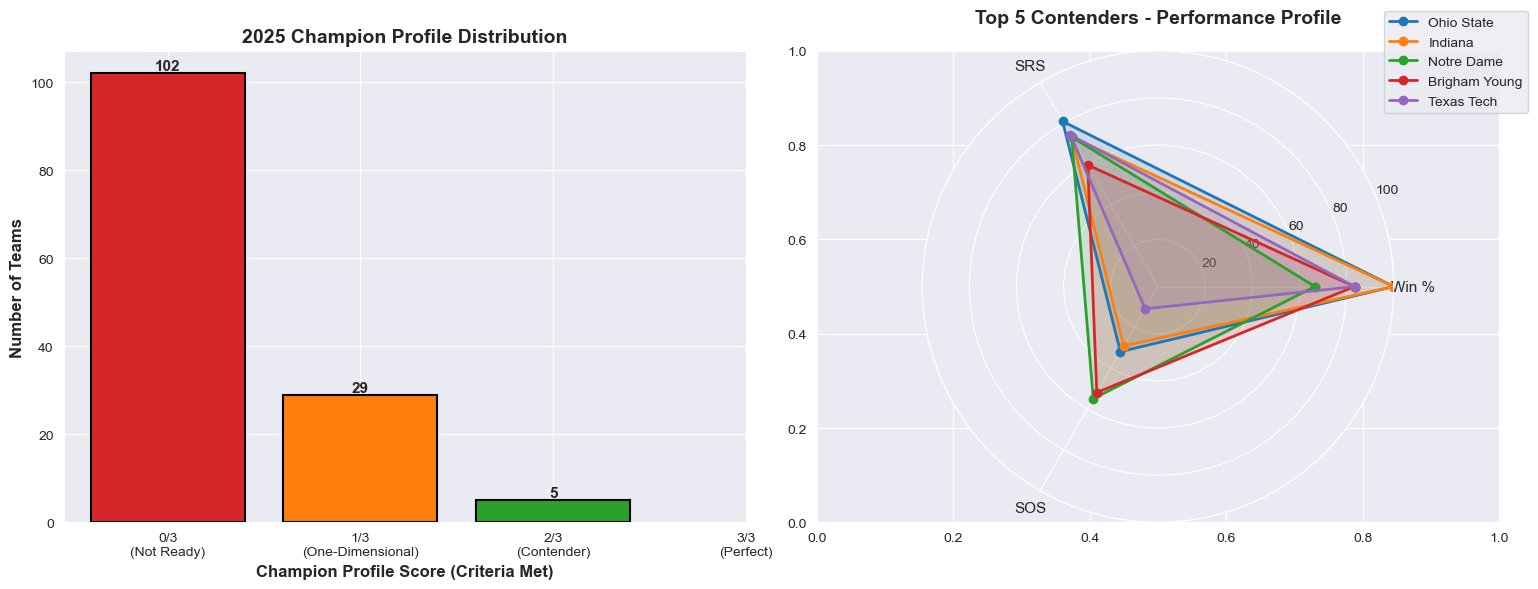

✅ Saved: IC2_2025_Profile_Analysis.png


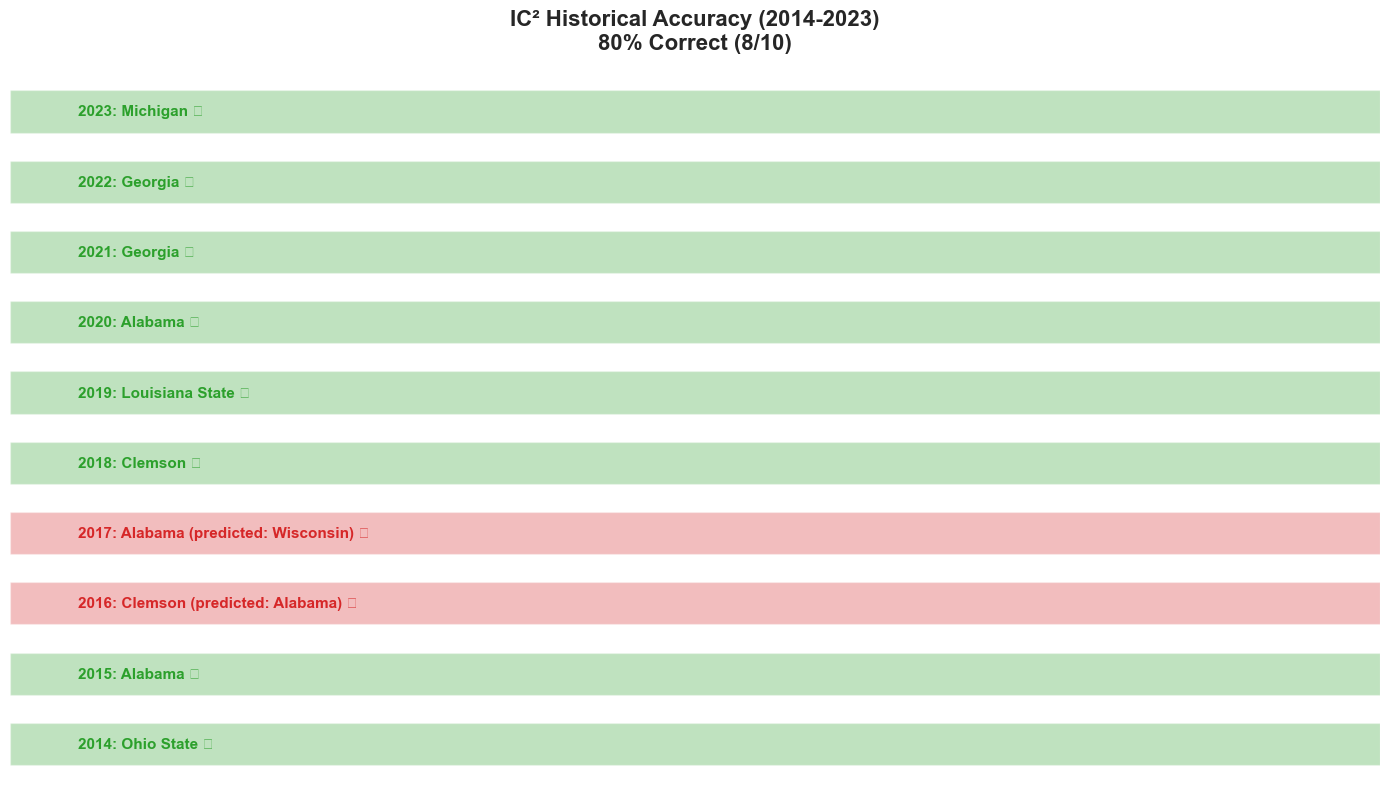

✅ Saved: IC2_Historical_Accuracy.png


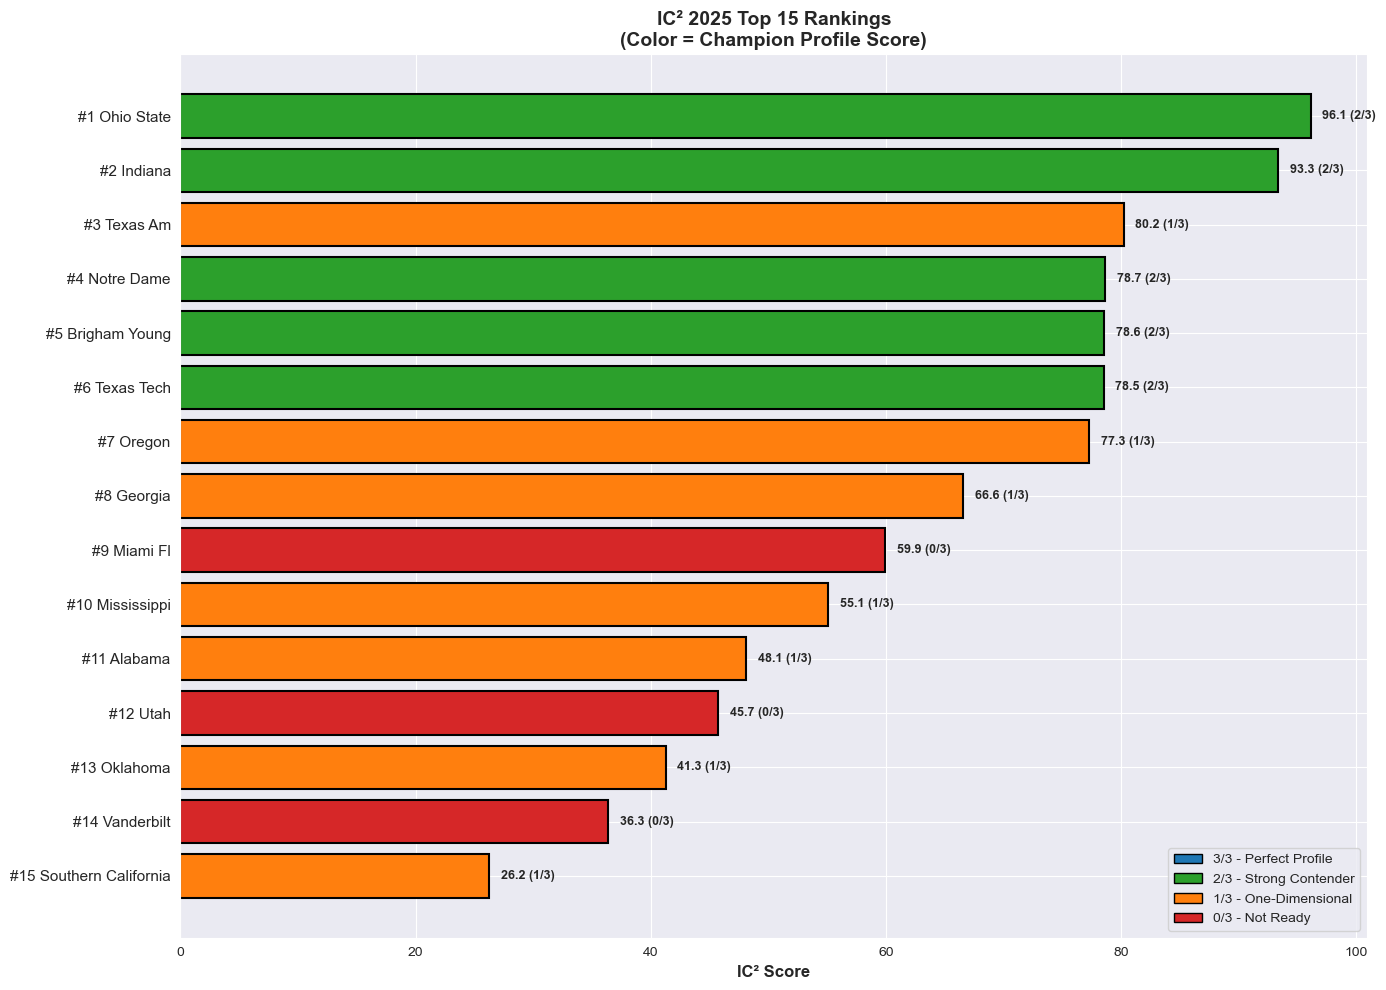

✅ Saved: IC2_2025_Top15_Rankings.png


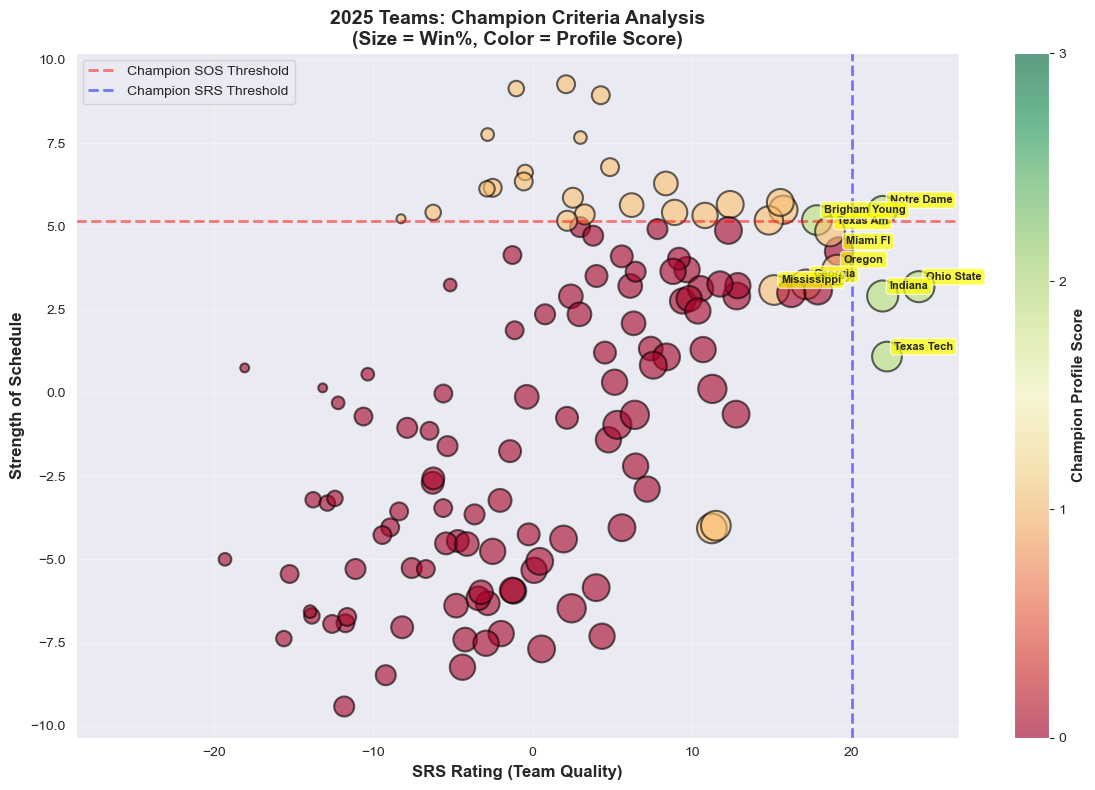

✅ Saved: IC2_2025_Criteria_Scatter.png

ALL VISUALIZATIONS CREATED! 🎨


In [3]:
# ============================================================================
# IC² PURE - DATA VISUALIZATIONS
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# ----------------------------
# VISUALIZATION 1: Champion Profile Distribution (2025)
# ----------------------------

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Profile distribution
df_2025 = df[df['Year'] == 2025].copy()
profile_counts = df_2025['champion_profile'].value_counts().sort_index()

colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
bars = ax1.bar(profile_counts.index, profile_counts.values, color=colors, edgecolor='black', linewidth=1.5)

ax1.set_xlabel('Champion Profile Score (Criteria Met)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Teams', fontsize=12, fontweight='bold')
ax1.set_title('2025 Champion Profile Distribution', fontsize=14, fontweight='bold')
ax1.set_xticks([0, 1, 2, 3])
ax1.set_xticklabels(['0/3\n(Not Ready)', '1/3\n(One-Dimensional)', '2/3\n(Contender)', '3/3\n(Perfect)'])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Right: Top contenders radar
contenders = df_2025[df_2025['champion_profile'] >= 2].sort_values('IC2_rank').head(5)

# Normalize stats for radar chart
def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val) * 100

categories = ['Win %', 'SRS', 'SOS']
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]

ax2 = plt.subplot(122, projection='polar')
colors_radar = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, (_, team) in enumerate(contenders.iterrows()):
    values = [
        normalize(team['Overall_Pct'], 0.5, 1.0),
        normalize(team['SRS_SRS'], 0, 30),
        normalize(team['SRS_SOS'], 0, 10)
    ]
    values += values[:1]
    
    team_name = team['school_key'].replace('-', ' ').title()
    ax2.plot(angles, values, 'o-', linewidth=2, label=team_name, color=colors_radar[idx])
    ax2.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories, fontsize=11)
ax2.set_ylim(0, 100)
ax2.set_title('Top 5 Contenders - Performance Profile', fontsize=14, fontweight='bold', pad=20)
ax2.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax2.grid(True)

plt.tight_layout()
plt.savefig('IC2_2025_Profile_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: IC2_2025_Profile_Analysis.png")

# ----------------------------
# VISUALIZATION 2: Historical Accuracy Timeline
# ----------------------------

fig, ax = plt.subplots(figsize=(14, 8))

# Get historical predictions
years = range(2014, 2024)
actual = []
predicted = []
correct = []

for year in years:
    actual_champ = df[(df['Year'] == year) & (df['champion_target'] == 1)]
    predicted_champ = df[(df['Year'] == year) & (df['IC2_rank'] == 1)]
    
    if not actual_champ.empty and not predicted_champ.empty:
        actual_name = actual_champ.iloc[0]['school_key'].replace('-', ' ').title()
        predicted_name = predicted_champ.iloc[0]['school_key'].replace('-', ' ').title()
        
        actual.append(actual_name)
        predicted.append(predicted_name)
        correct.append(actual_name == predicted_name)

# Plot
y_positions = np.arange(len(years))
colors_timeline = ['#2ca02c' if c else '#d62728' for c in correct]

ax.barh(y_positions, [1]*len(years), color=colors_timeline, alpha=0.3, height=0.6)

for i, (year, act, pred, corr) in enumerate(zip(years, actual, predicted, correct)):
    symbol = "✓" if corr else "✗"
    color = '#2ca02c' if corr else '#d62728'
    
    if corr:
        text = f"{year}: {act} {symbol}"
    else:
        text = f"{year}: {act} (predicted: {pred}) {symbol}"
    
    ax.text(0.05, i, text, va='center', fontsize=11, fontweight='bold', color=color)

ax.set_yticks([])
ax.set_xlim(0, 1)
ax.set_ylim(-0.5, len(years) - 0.5)
ax.axis('off')
ax.set_title('IC² Historical Accuracy (2014-2023)\n80% Correct (8/10)', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('IC2_Historical_Accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: IC2_Historical_Accuracy.png")

# ----------------------------
# VISUALIZATION 3: 2025 Top 15 Rankings with Profile Indicators
# ----------------------------

fig, ax = plt.subplots(figsize=(14, 10))

top15 = df_2025.sort_values('IC2_rank').head(15)

# Create horizontal bars
y_pos = np.arange(len(top15))
scores = top15['IC2_score'].values
profiles = top15['champion_profile'].values

# Color based on profile
bar_colors = []
for profile in profiles:
    if profile == 3:
        bar_colors.append('#1f77b4')  # Blue - Perfect
    elif profile == 2:
        bar_colors.append('#2ca02c')  # Green - Strong
    elif profile == 1:
        bar_colors.append('#ff7f0e')  # Orange - One-dimensional
    else:
        bar_colors.append('#d62728')  # Red - Not ready

bars = ax.barh(y_pos, scores, color=bar_colors, edgecolor='black', linewidth=1.5)

# Labels
team_names = [name.replace('-', ' ').title() for name in top15['school_key']]
ax.set_yticks(y_pos)
ax.set_yticklabels([f"#{i+1} {name}" for i, name in enumerate(team_names)], fontsize=11)
ax.set_xlabel('IC² Score', fontsize=12, fontweight='bold')
ax.set_title('IC² 2025 Top 15 Rankings\n(Color = Champion Profile Score)', 
             fontsize=14, fontweight='bold')
ax.invert_yaxis()

# Add score labels
for i, (bar, score, profile) in enumerate(zip(bars, scores, profiles)):
    ax.text(score + 1, bar.get_y() + bar.get_height()/2, 
            f'{score:.1f} ({int(profile)}/3)',
            va='center', fontweight='bold', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', edgecolor='black', label='3/3 - Perfect Profile'),
    Patch(facecolor='#2ca02c', edgecolor='black', label='2/3 - Strong Contender'),
    Patch(facecolor='#ff7f0e', edgecolor='black', label='1/3 - One-Dimensional'),
    Patch(facecolor='#d62728', edgecolor='black', label='0/3 - Not Ready')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('IC2_2025_Top15_Rankings.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: IC2_2025_Top15_Rankings.png")

# ----------------------------
# VISUALIZATION 4: Champion Criteria Scatter Plot
# ----------------------------

fig, ax = plt.subplots(figsize=(12, 8))

# Get 2025 data
df_plot = df_2025.copy()

# Create scatter plot
scatter = ax.scatter(df_plot['SRS_SRS'], df_plot['SRS_SOS'], 
                    s=df_plot['Overall_Pct'] * 500,  # Size by win%
                    c=df_plot['champion_profile'], 
                    cmap='RdYlGn', 
                    alpha=0.6,
                    edgecolors='black',
                    linewidth=1.5,
                    vmin=0, vmax=3)

# Add threshold lines
ax.axhline(y=5.17, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Champion SOS Threshold')
ax.axvline(x=20.08, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Champion SRS Threshold')

# Label top teams
top10 = df_plot.sort_values('IC2_rank').head(10)
for _, team in top10.iterrows():
    team_name = team['school_key'].replace('-', ' ').title()
    ax.annotate(team_name, 
               (team['SRS_SRS'], team['SRS_SOS']),
               xytext=(5, 5), textcoords='offset points',
               fontsize=8, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.set_xlabel('SRS Rating (Team Quality)', fontsize=12, fontweight='bold')
ax.set_ylabel('Strength of Schedule', fontsize=12, fontweight='bold')
ax.set_title('2025 Teams: Champion Criteria Analysis\n(Size = Win%, Color = Profile Score)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, ticks=[0, 1, 2, 3])
cbar.set_label('Champion Profile Score', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('IC2_2025_Criteria_Scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Saved: IC2_2025_Criteria_Scatter.png")

print("\n" + "="*80)
print("ALL VISUALIZATIONS CREATED! 🎨")
print("="*80)